In [1]:
from sklearn import metrics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

from statsmodels.stats.proportion import proportions_ztest

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,MinMaxScaler
mms=MinMaxScaler()
sc=StandardScaler()

from sklearn.model_selection import GridSearchCV

import scikitplot as skplt

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score,cross_val_predict



from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [2]:
bank=pd.read_csv('bank-full.csv',delimiter=';')

bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
main_df=bank.copy(deep=True)

###### Reducing skewness of the balance

In [4]:
main_df['balance'].skew()

8.360308326166326

In [5]:
np.cbrt(main_df['balance']).skew()

-0.07818749236478738

In [6]:
main_df['balance']=np.cbrt(main_df['balance'])

###### Reducing skewness of the duration

In [7]:
main_df['duration'].skew()

3.144318099423456

In [8]:
np.cbrt(main_df['duration']).skew()

0.64014649967056

In [9]:
main_df[main_df['duration']==0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
6424,53,management,married,primary,no,7.054004,yes,no,unknown,27,may,0,4,-1,0,unknown,no
22937,35,technician,married,secondary,no,17.689106,no,no,cellular,26,aug,0,15,-1,0,unknown,no
36425,31,entrepreneur,married,secondary,no,5.451362,yes,yes,cellular,11,may,0,2,-1,0,unknown,no


In [10]:
main_df['duration']=np.cbrt(main_df['duration'])

In [11]:
main_df['y']=main_df['y'].replace(['no','yes'],[0, 1])

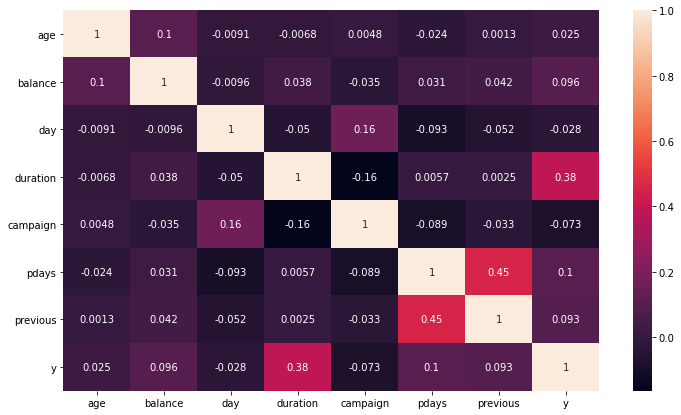

In [12]:
corr_columns = bank.select_dtypes(include=np.number)
plt.figure(figsize=(12,7))
sns.heatmap(main_df.corr(),annot=True)
plt.show()

In [13]:
#Due to high Correlation dropping Duration
main_df.drop('duration',axis=1,inplace=True)

#### Conversion

In [14]:
cat_cols = main_df.select_dtypes(include=[
        'object']).columns
df = pd.get_dummies(main_df, columns=cat_cols,drop_first=True)

#standard Scaler for Numerical Variables
scaler = StandardScaler()
num_cols = main_df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('y')
#df[num_cols] = scaler.fit_transform(df[num_cols])

In [15]:
num_cols

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')

In [16]:
X = df.drop(columns=['y'])

X_scaled=scaler.fit_transform(X)
y =main_df['y']
print(X.shape)
print(y.shape)

y.value_counts().to_frame()

(45211, 41)
(45211,)


,y
0,39922
1,5289


In [17]:
X_scaled

array([[ 1.60696496,  0.8255281 , -1.29847633, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [ 0.28852927, -0.66562455, -1.29847633, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [-0.74738448, -0.94082609, -1.29847633, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       ...,
       [ 2.92540065,  1.58265436,  0.14341818, ..., -0.20597248,
         5.37784754, -2.11631591],
       [ 1.51279098,  0.19522617,  0.14341818, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [-0.37068857,  1.05075328,  0.14341818, ...,  4.85501757,
        -0.185948  , -2.11631591]])

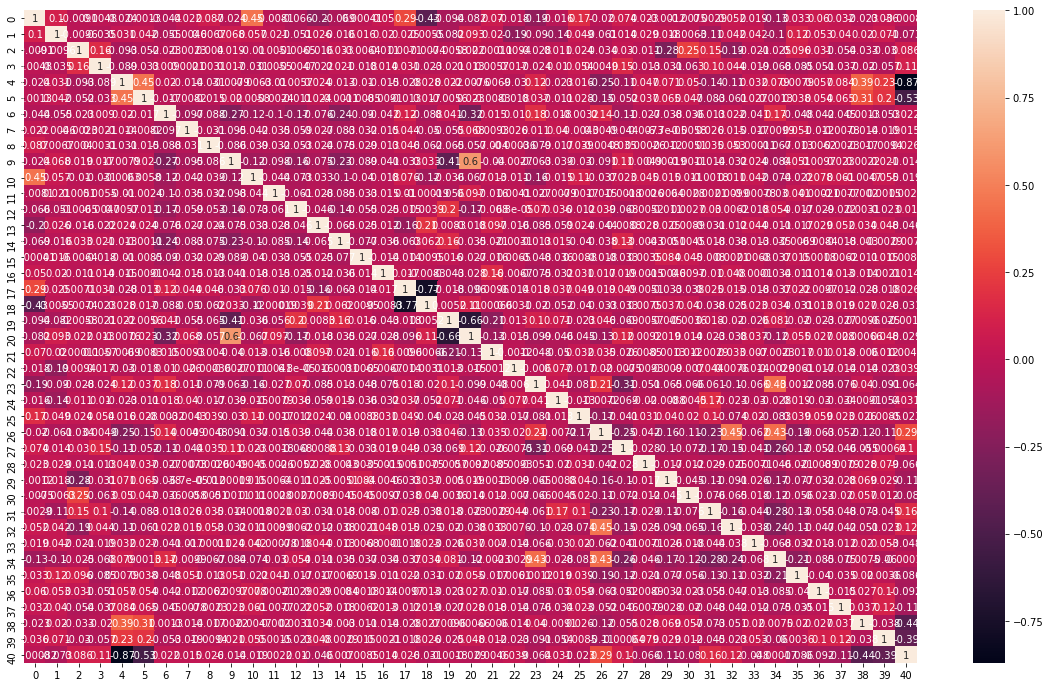

In [18]:
plt.figure(figsize=(20,12))
sns.heatmap(pd.DataFrame(X_scaled).corr(),annot=True)

### CLUSTERING

In [19]:
from sklearn.cluster import KMeans

In [20]:
cluster_range=np.arange(1,10)
cluster_error=[]
for num_cluster in cluster_range:
    cluster=KMeans(num_cluster,n_init=10)
    cluster.fit(X_scaled)
    centroids=cluster.cluster_centers_
    cluster_error.append(cluster.inertia_)
cluster_df=pd.DataFrame({'num_cluster':cluster_range,
                        'cluster_error':cluster_error})
cluster_df

,num_cluster,cluster_error
0,1,1.853651e+06
1,2,1.735611e+06
2,3,1.653160e+06
3,4,1.597574e+06
4,5,1.552912e+06
5,6,1.504702e+06
6,7,1.459162e+06
7,8,1.427081e+06
8,9,1.381569e+06


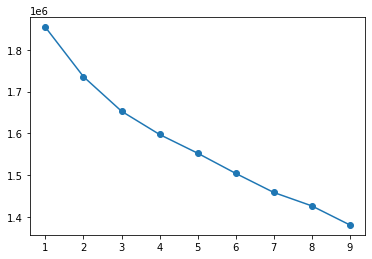

In [21]:
plt.plot(cluster_df.num_cluster,cluster_df.cluster_error,marker='o')

In [25]:
kmean=KMeans(n_clusters=3,n_init=15,random_state=2345)
kmean.fit(X_scaled)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [26]:
centroid=kmean.cluster_centers_
centroid=pd.DataFrame(centroid)
centroid['Labels']=[0,1,2]
centroid

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Labels
0,0.000566,0.153763,-0.185981,-0.228027,1.854022,1.134108,-0.044018,-0.030302,-0.060224,0.027786,...,-0.244894,0.103581,0.004911,0.183954,0.198955,0.226161,0.931607,0.841036,-2.115683,0
1,-0.105181,-0.104138,-0.129004,-0.022244,-0.411386,-0.251751,0.264065,0.001330,-0.029652,-0.165382,...,0.549209,-0.102041,0.816451,-0.308059,-0.112572,-0.101136,-0.205972,-0.185948,0.471712,1
2,0.080078,0.019553,0.170997,0.105886,-0.408788,-0.249976,-0.184433,0.010799,0.046117,0.115424,...,-0.323803,0.037517,-0.625219,0.163461,0.008371,-0.010966,-0.205972,-0.185948,0.464751,2


In [27]:
df_labels=pd.DataFrame(kmean.labels_,columns=['labels'])
df_labels['labels']=df_labels['labels'].astype('category')

In [28]:
final=main_df.join(df_labels)

In [29]:
final.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,labels
0,58,management,married,tertiary,no,12.892606,yes,no,unknown,5,may,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,3.072317,yes,no,unknown,5,may,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,1.259921,yes,yes,unknown,5,may,1,-1,0,unknown,0,1
3,47,blue-collar,married,unknown,no,11.462385,yes,no,unknown,5,may,1,-1,0,unknown,0,1
4,33,unknown,single,unknown,no,1.000000,no,no,unknown,5,may,1,-1,0,unknown,0,1


In [30]:
final['labels'].value_counts()

2    20995
1    16030
0     8186
Name: labels, dtype: int64

In [31]:
final['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [32]:
final['labels']=final['labels'].astype('int64')

In [33]:
cat_cols = main_df.select_dtypes(include=[
        'object']).columns
df = pd.get_dummies(main_df, columns=cat_cols,drop_first=True)

#standard Scaler for Numerical Variables
scaler = StandardScaler()
num_cols = main_df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('y')
df[num_cols] = scaler.fit_transform(df[num_cols])

In [34]:
X = df.drop(columns=['y'])

y =final['labels']
print(X.shape)
print(y.shape)

y.value_counts().to_frame()

(45211, 41)
(45211,)


,labels
2,20995
1,16030
0,8186


In [35]:
X

,age,balance,day,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.825528,-1.298476,-0.569351,-0.411453,-0.251940,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0.288529,-0.665625,-1.298476,-0.569351,-0.411453,-0.251940,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,-0.747384,-0.940826,-1.298476,-0.569351,-0.411453,-0.251940,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.571051,0.608357,-1.298476,-0.569351,-0.411453,-0.251940,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,-0.747384,-0.980294,-1.298476,-0.569351,-0.411453,-0.251940,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.947747,0.291991,0.143418,0.076230,-0.411453,-0.251940,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45207,2.831227,0.690343,0.143418,-0.246560,-0.411453,-0.251940,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45208,2.925401,1.582654,0.143418,0.721811,1.436189,1.050473,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
45209,1.512791,0.195226,0.143418,0.399020,-0.411453,-0.251940,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [36]:
X.columns

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

#### Algorithm function

In [44]:
def algorithm(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    
    model.fit(X_train,y_train)
    
    y_test_model_predict=model.predict(X_test)
    
    print('CLASSIFICATION REFORT')
    print(classification_report(y_test, y_test_model_predict))
    
    print('CONFUSION MATRIX')
    skplt.metrics.plot_confusion_matrix(y_test,y_test_model_predict)

#### Logistic Regression model

#### XGB

[00:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CLASSIFICATION REFORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2491
           1       1.00      0.99      1.00      4835
           2       1.00      1.00      1.00      6238

    accuracy                           1.00     13564
   macro avg       1.00      1.00      1.00     13564
weighted avg       1.00      1.00      1.00     13564

CONFUSION MATRIX


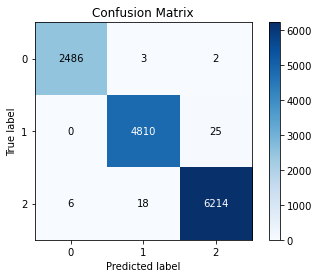

In [38]:
#### XGBoost Classifier

xgb = XGBClassifier(use_label_encoder=False)
algorithm(xgb,X,y)

### Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

CLASSIFICATION REFORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2491
           1       0.90      0.99      0.94      4835
           2       0.99      0.91      0.95      6238

    accuracy                           0.95     13564
   macro avg       0.96      0.97      0.96     13564
weighted avg       0.96      0.95      0.95     13564

CONFUSION MATRIX


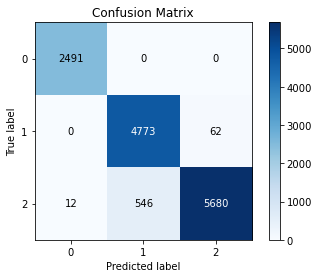

In [45]:
NB=GaussianNB()
algorithm(NB,X,y)

In [38]:
main_df2=main_df.copy(deep=True)

In [39]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



## ----------------------------------------------------------------------------------------------------------------------------------

In [40]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [41]:
main_df['job']=le.fit_transform(main_df['job'])

In [42]:
main_df['month']=le.fit_transform(main_df['month'])
main_df['poutcome']=le.fit_transform(main_df['poutcome'])
main_df['contact']=le.fit_transform(main_df['contact'])
main_df['education']=le.fit_transform(main_df['education'])
main_df['marital']=le.fit_transform(main_df['marital'])

In [43]:
main_df[['default','housing','loan']]=pd.get_dummies(main_df[['default','housing','loan']],drop_first=True)

In [44]:
main_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,12.892606,1,0,2,5,8,1,-1,0,3,0
1,44,9,2,1,0,3.072317,1,0,2,5,8,1,-1,0,3,0
2,33,2,1,1,0,1.259921,1,1,2,5,8,1,-1,0,3,0
3,47,1,1,3,0,11.462385,1,0,2,5,8,1,-1,0,3,0
4,33,11,2,3,0,1.000000,0,0,2,5,8,1,-1,0,3,0


In [45]:
X00=main_df.drop('y',axis=1)
X00=scaler.fit_transform(X00)

In [46]:
X00

array([[ 1.60696496, -0.10381968, -0.27576178, ..., -0.41145311,
        -0.25194037,  0.44489814],
       [ 0.28852927,  1.42400783,  1.3683719 , ..., -0.41145311,
        -0.25194037,  0.44489814],
       [-0.74738448, -0.71495069, -0.27576178, ..., -0.41145311,
        -0.25194037,  0.44489814],
       ...,
       [ 2.92540065,  0.20174582, -0.27576178, ...,  1.43618859,
         1.05047333, -0.56617504],
       [ 1.51279098, -1.02051619, -0.27576178, ..., -0.41145311,
        -0.25194037,  0.44489814],
       [-0.37068857, -0.71495069, -0.27576178, ...,  1.4761376 ,
         4.52357654, -1.57724822]])

In [47]:
cluster_range=np.arange(1,10)
cluster_error=[]
for num_cluster in cluster_range:
    cluster=KMeans(num_cluster,n_init=10)
    cluster.fit(X00)
    centroids=cluster.cluster_centers_
    cluster_error.append(cluster.inertia_)
cluster_df=pd.DataFrame({'num_cluster':cluster_range,
                        'cluster_error':cluster_error})
cluster_df

,num_cluster,cluster_error
0,1,678165.000000
1,2,584917.170989
2,3,534283.655637
3,4,489140.535059
4,5,463007.344027
5,6,435615.497989
6,7,418316.188931
7,8,397099.009068
8,9,385838.710843


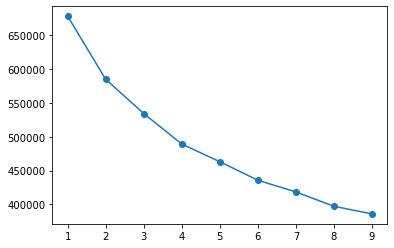

In [48]:
plt.plot(cluster_df.num_cluster,cluster_df.cluster_error,marker='o')

In [62]:
kmean=KMeans(n_clusters=3,n_init=15,random_state=2345)
kmean.fit(X_scaled)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [64]:
centroid=kmean.cluster_centers_
centroid=pd.DataFrame(centroid)
centroid['Labels']=[0,1,2]
centroid

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Labels
0,0.000566,0.153763,-0.185981,-0.228027,1.854022,1.134108,-0.044018,-0.030302,-0.060224,0.027786,...,-0.244894,0.103581,0.004911,0.183954,0.198955,0.226161,0.931607,0.841036,-2.115683,0
1,-0.105181,-0.104138,-0.129004,-0.022244,-0.411386,-0.251751,0.264065,0.001330,-0.029652,-0.165382,...,0.549209,-0.102041,0.816451,-0.308059,-0.112572,-0.101136,-0.205972,-0.185948,0.471712,1
2,0.080078,0.019553,0.170997,0.105886,-0.408788,-0.249976,-0.184433,0.010799,0.046117,0.115424,...,-0.323803,0.037517,-0.625219,0.163461,0.008371,-0.010966,-0.205972,-0.185948,0.464751,2


In [65]:
df_labels=pd.DataFrame(kmean.labels_,columns=['labels'])
df_labels['labels']=df_labels['labels'].astype('category')

In [66]:
final=main_df2.join(df_labels)

In [67]:
final.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,labels
0,58,management,married,tertiary,no,12.892606,yes,no,unknown,5,may,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,3.072317,yes,no,unknown,5,may,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,1.259921,yes,yes,unknown,5,may,1,-1,0,unknown,0,1
3,47,blue-collar,married,unknown,no,11.462385,yes,no,unknown,5,may,1,-1,0,unknown,0,1
4,33,unknown,single,unknown,no,1.000000,no,no,unknown,5,may,1,-1,0,unknown,0,1


In [68]:
final['labels'].value_counts()

2    20995
1    16030
0     8186
Name: labels, dtype: int64

In [69]:
final['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [70]:
cat_cols = main_df2.select_dtypes(include=[
        'object']).columns
df = pd.get_dummies(main_df2, columns=cat_cols,drop_first=True)

#standard Scaler for Numerical Variables
scaler = StandardScaler()
num_cols = main_df2.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('y')
df[num_cols] = scaler.fit_transform(df[num_cols])

In [71]:
X = df.drop(columns=['y'])

y =final['labels']
print(X.shape)
print(y.shape)

y.value_counts().to_frame()

(45211, 41)
(45211,)


,labels
2,20995
1,16030
0,8186


### Naive Bayes

In [72]:
from sklearn.naive_bayes import GaussianNB

CLASSIFICATION REFORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2491
           1       0.90      0.99      0.94      4835
           2       0.99      0.91      0.95      6238

    accuracy                           0.95     13564
   macro avg       0.96      0.97      0.96     13564
weighted avg       0.96      0.95      0.95     13564

CONFUSION MATRIX


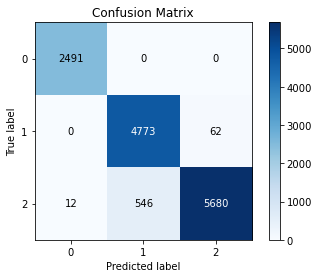

In [73]:
NB=GaussianNB()
algorithm(NB,X,y)

#### XGB

[17:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CLASSIFICATION REFORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1548
           1       0.99      1.00      1.00      2468
           2       1.00      1.00      1.00      6203
           3       1.00      0.99      1.00      3345

    accuracy                           1.00     13564
   macro avg       1.00      1.00      1.00     13564
weighted avg       1.00      1.00      1.00     13564

CONFUSION MATRIX


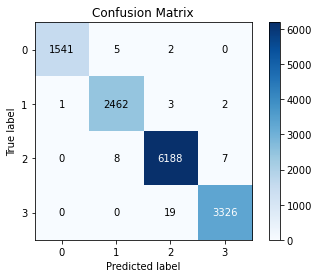

In [61]:
#### XGBoost Classifier

xgb = XGBClassifier(use_label_encoder=False)
algorithm(xgb,X,y)

In [ ]:
NB=GaussianNB()
algorithm(NB,X,y)